In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
data_path = "/content/BBNI.JK.csv"
df = pd.read_csv(data_path)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,4400.0,4400.0,4400.0,4400.0,3718.353516,0
1,2019-01-02,4400.0,4400.0,4337.5,4362.5,3686.663574,15681200
2,2019-01-03,4337.5,4387.5,4325.0,4362.5,3686.663574,21416600
3,2019-01-04,4362.5,4400.0,4337.5,4362.5,3686.663574,41078600
4,2019-01-07,4412.5,4462.5,4412.5,4437.5,3750.044189,48108200
...,...,...,...,...,...,...,...
1474,2025-01-09,4360.0,4410.0,4350.0,4380.0,4380.000000,25545500
1475,2025-01-10,4380.0,4420.0,4350.0,4350.0,4350.000000,28235300
1476,2025-01-13,4320.0,4330.0,4200.0,4210.0,4210.000000,54029800
1477,2025-01-14,4170.0,4240.0,4110.0,4130.0,4130.000000,71568000


In [3]:
# Memastikan data memiliki kolom yang sesuai
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df = df[['Close']]

In [4]:
df.head()

,Close
Date,
2019-01-01,4400.0
2019-01-02,4362.5
2019-01-03,4362.5
2019-01-04,4362.5
2019-01-07,4437.5


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

In [6]:
# Membuat dataset time series
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

look_back = 60  # Gunakan 60 hari terakhir untuk memprediksi hari berikutnya
X, y = create_dataset(scaled_data, look_back)

In [7]:
# Membagi dataset menjadi data latih dan data uji
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Menyesuaikan dimensi untuk LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics=['mae'])

In [12]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0766 - mae: 0.1900 - val_loss: 0.0063 - val_mae: 0.0680
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0049 - mae: 0.0523 - val_loss: 0.0026 - val_mae: 0.0403
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0040 - mae: 0.0469 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0032 - mae: 0.0434 - val_loss: 0.0044 - val_mae: 0.0522
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0038 - mae: 0.0462 - val_loss: 0.0018 - val_mae: 0.0344
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0028 - mae: 0.0408 - val_loss: 0.0022 - val_mae: 0.0358
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0028 - mae: 0.0402 - val_loss: 0.0021 - val_mae: 0.0352
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0027 - mae: 0.0393 - val_loss: 0.0016 - val_mae: 0.0330
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - 

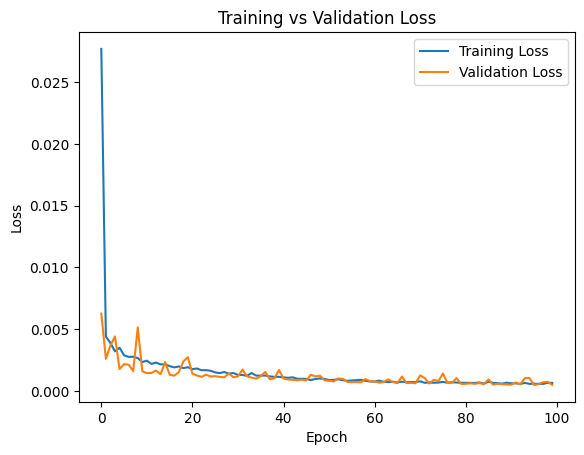

In [13]:
# Plot loss dan val_loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [14]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Denormalisasi hasil prediksi
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [15]:
print(y_test_actual[:5])

[[4940.]
 [4880.]
 [4860.]
 [4860.]
 [4890.]]


In [16]:
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 75.50
Mean Squared Error (MSE): 10427.64
Root Mean Squared Error (RMSE): 102.12


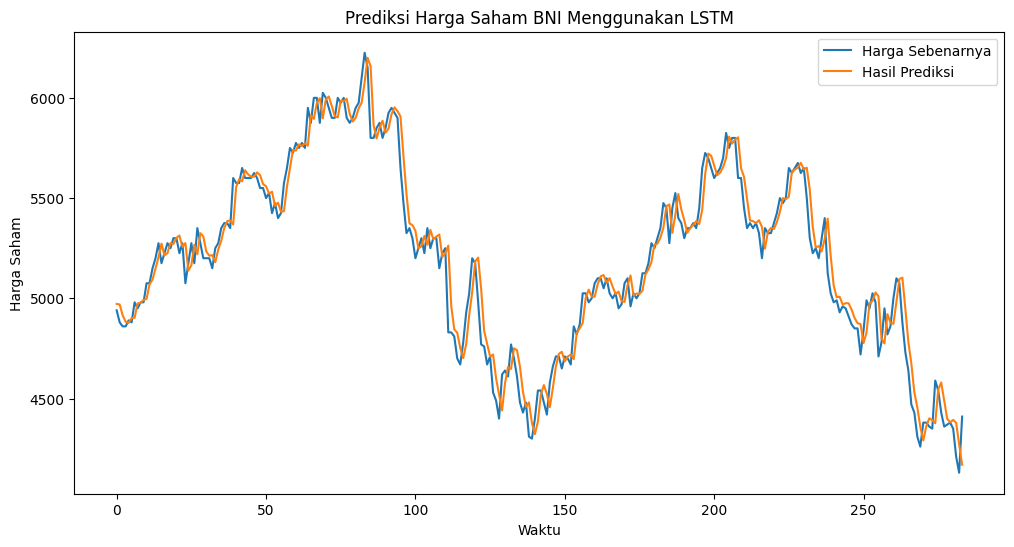

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Harga Sebenarnya")
plt.plot(y_pred, label="Hasil Prediksi")
plt.title("Prediksi Harga Saham BNI Menggunakan LSTM")
plt.xlabel("Waktu")
plt.ylabel("Harga Saham")
plt.legend()
plt.show()

In [18]:
model.save("BBNI_LSTM_model.h5")